In [4]:
import pandas as pd

root_dir = 'covid-chestxray-dataset/'
image_dir = 'images/'

df = pd.read_csv('clean_data.csv')

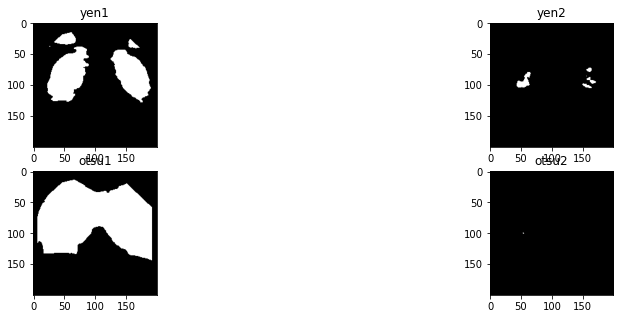

In [5]:
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
import skimage.filters as flt
import skimage.exposure as expo

length = 200
current = df.iloc[0]
img_loc = root_dir + image_dir + current['filename']

coarse_mask = img_as_ubyte(io.imread('coarse_mask.png', as_gray=True))

try:
    img = img_as_ubyte(io.imread(img_loc, as_gray=True))
    y_len, x_len = img.shape
    
    if y_len > x_len:    # height > width
        img = resize(img, [ round(length*y_len/x_len), length ])
        y_len = img.shape[0]
        crop_length = y_len - length
        img = img[ :y_len-crop_length , : ]    # crop from bottom
        
    elif y_len < x_len:    # height < width
        
        img = resize(img, [ length, round(length*x_len/y_len) ])
        x_len = img.shape[1]
        crop_length = x_len - length
        half_crop = crop_length//2
        img = img[ : , half_crop:x_len-half_crop ]    # crop on left and right
        
        if img.shape[0] != img.shape[1]:
            img = img[ : , :length ]    # make sure image is square
        
    else:    # height == width
        img = resize(img, [ length, length ])
    
    img = flt.gaussian(img)
    
    # coarse mask -> thresholding
    masked = ~(img_as_ubyte(img) * coarse_mask)
    thresh = flt.threshold_yen(masked)
    binary1 = masked <= thresh
    
    # thresholding -> coarse mask
    thresh = flt.threshold_yen(~img_as_ubyte(img))
    masked = ~(img_as_ubyte(img) * coarse_mask)
    binary2 =  masked <= thresh
    
    # coarse mask -> thresholding
    masked = ~(img_as_ubyte(img) * coarse_mask)
    thresh = flt.threshold_otsu(masked)
    binary3 = masked <= thresh
    
    # thresholding -> coarse mask
    thresh = flt.threshold_otsu(~img_as_ubyte(img))
    masked = ~(img_as_ubyte(img) * coarse_mask)
    binary4 =  masked <= thresh
    
    # adjust contrast sample (cm -> t)
    #gamma = expo.adjust_gamma(img, 2)
    #log = expo.adjust_log(gamma, 1)
    #masked = ~(img_as_ubyte(log) * coarse_mask)
    #thresh = flt.threshold_yen(masked)
    #binary3 = masked <= thresh
    
    # adjust contrast sample (t -> cm)
    #gamma = expo.adjust_gamma(img, 2)
    #log = expo.adjust_log(gamma, 1)
    #thresh = flt.threshold_yen(~img_as_ubyte(log))
    #masked = ~(img_as_ubyte(log) * coarse_mask)
    #binary4 =  masked <= thresh
    
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,5))
    ax0.title.set_text('yen1')
    ax1.title.set_text('yen2')
    ax2.title.set_text('otsu1')
    ax3.title.set_text('otsu2')
    #ax2.title.set_text('c -> cm -> t')
    #ax3.title.set_text('c -> t -> cm')
    
    ax0.imshow(binary1, cmap=plt.cm.gray)
    ax1.imshow(binary2, cmap=plt.cm.gray)
    ax2.imshow(binary3, cmap=plt.cm.gray)
    ax3.imshow(binary4, cmap=plt.cm.gray)
    
except FileNotFoundError:
    print(f'{img_loc} not found.')

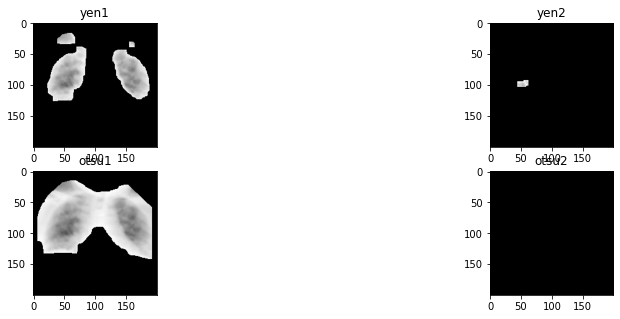

In [6]:
from skimage.morphology import square, dilation, erosion, opening, closing

# dilatation and erosion
kernel = square(7)
op = opening(binary1, kernel)
cl = closing(op, kernel)
final1 = img * cl

op = opening(binary2, kernel)
cl = closing(op, kernel)
final2 = img * cl

op = opening(binary3, kernel)
cl = closing(op, kernel)
final3 = img * cl

op = opening(binary4, kernel)
cl = closing(op, kernel)
final4 = img * cl

f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,5))
ax0.title.set_text('yen1')
ax1.title.set_text('yen2')
ax2.title.set_text('otsu1')
ax3.title.set_text('otsu2')
#ax2.title.set_text('c -> cm -> t')
#ax3.title.set_text('c -> t -> cm')

ax0.imshow(final1, cmap=plt.cm.gray)
ax1.imshow(final2, cmap=plt.cm.gray)
ax2.imshow(final3, cmap=plt.cm.gray)
ax3.imshow(final4, cmap=plt.cm.gray)

COVID-19


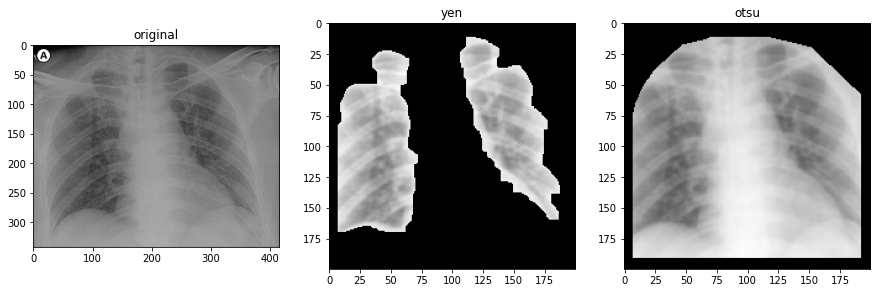

In [326]:
img = img_as_ubyte(io.imread(img_loc, as_gray=True))

print(current['finding'])

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,5))
ax0.title.set_text('original')
ax1.title.set_text('yen')
ax2.title.set_text('otsu')

ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(final1, cmap=plt.cm.gray)
ax2.imshow(final3, cmap=plt.cm.gray)